### Prompt Chaining example

`Workflow`: 
Start -> topic -> (LLM - generate outline of the topic) -> (LLM - generate a blog with topic + outline) -> End 

- Also add evaluation

In [11]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from typing import TypedDict

In [12]:
load_dotenv()
llm = ChatOpenAI(model = "gpt-4.1-nano", temperature=0)

In [13]:
# Define state
class BlogState(TypedDict):
    topic: str
    outline: str
    blog: str
    evaluation_score: float

In [14]:
def generate_outline(state: BlogState) -> BlogState:

    # extract topic from the state
    topic = state['topic']

    # create a prompt
    prompt = f"Generate a detailed outline for a blog post about this topic: {topic}"

    # invoke the LLM
    outline = llm.invoke(prompt).content

    # update the state
    state['outline'] = outline

    # return the state
    return state

In [15]:
def generate_blog(state: BlogState) -> BlogState:

    # extract topic and outline from the state
    topic = state['topic']
    outline = state['outline']

    # create a prompt
    prompt = f"""Generate a detailed blog post about this topic and its outline:
    
    Topic: {topic}

    Outline: {outline}"""

    # invoke the LLM
    blog = llm.invoke(prompt).content

    # update the state
    state['blog'] = blog

    # return the state
    return state

In [25]:
def evaluate_blog(state: BlogState) -> BlogState:
    outline = state['outline']
    blog = state['blog']

    # create a prompt
    prompt = f"""Evaluate this blog post
    
    based on its outline and content :
    Outline: {outline}

    Content: {blog}

    On a scale of 0 to 10, how would you rate this blog post?
    
    Note: only give the evaluation score and nothing else"""

    # invoke the LLM
    evaluation = llm.invoke(prompt).content

    # update the state
    state['evaluation_score'] = round(float(evaluation), 2)  # round evaluation

    # return the state
    return state


In [26]:
# Define graph
graph = StateGraph(BlogState)

# step 1: add nodes to graph
graph.add_node('generate_outline', generate_outline)
graph.add_node('generate_blog', generate_blog)
graph.add_node('evaluate_blog', evaluate_blog)

# step 2: add edges to graph
graph.add_edge(START, 'generate_outline')
graph.add_edge('generate_outline', 'generate_blog')
graph.add_edge('generate_blog', 'evaluate_blog')
graph.add_edge('evaluate_blog', END)

# step 3: compile the graph
workflow = graph.compile()

In [27]:
# step 4: run the workflow
initial_state = {'topic': 'Chinese Society'}
final_state = workflow.invoke(initial_state)
print(final_state)

{'topic': 'Chinese Society', 'outline': '**Blog Post Outline: Understanding Chinese Society**\n\n**I. Introduction**\n   - Brief overview of China’s significance in the world\n   - Importance of understanding Chinese society to grasp its culture, economy, and global influence\n   - Purpose and scope of the blog post\n\n**II. Historical Context**\n   - Ancient China: Dynasties, Confucianism, and cultural foundations\n   - Major historical events shaping modern society (e.g., Opium Wars, Cultural Revolution)\n   - Transition from imperial to communist society\n\n**III. Social Structure and Hierarchies**\n   - Traditional family and filial piety\n   - Class structure: urban vs. rural divides\n   - Role of social status and reputation (face culture)\n   - Modern shifts in social mobility\n\n**IV. Cultural Values and Norms**\n   - Confucian principles: respect, harmony, hierarchy\n   - Collectivism vs. individualism\n   - Importance of education and hard work\n   - Festivals, traditions, an

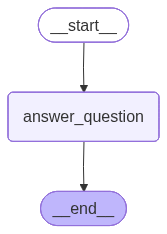

In [ ]:
# To visualize the graph
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())